In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%qtconsole

In [3]:
filepath = '/Volumes/hanash/Hanash_Lab_GPFS/Chunhui/100FDR/IPAS0993/SG_combined_protein.csv'

In [4]:
df = pd.read_csv(filepath, usecols=['protein.Accession', 'protein.dataBaseType', 'protein.score'])
df['protein.score'] = np.log(df['protein.score'] + 1)
df.head()

,protein.Accession,protein.dataBaseType,protein.score
0,H0Y449,Regular,9.620057
1,P67809,Regular,9.620057
2,P09651,Regular,9.363938
3,H0YH80,Regular,9.361616
4,A0A7I2YQY2,Regular,9.361616


# Subset only necessary proteins

In [6]:
uniprot_swiss =  pd.read_table("/Users/cgu3/Documents/Grape-Pi/data/miscellaneous/uniprotkb_proteome_UP000005640_AND_revi_2023_10_05.tsv", sep='\t')

In [7]:
# flag = np.logical_and(df['protein.Accession'].isin(uniprot_swiss['Entry']),  ~(df['protein.dataBaseType'] == 'Random')) # only Swissprot ~60, 000
# flag = np.logical_and(~df['protein.Accession'].isin(uniprot_swiss['Entry']), ~(df['protein.dataBaseType'] == 'Random')) # only Trembl ~ 212, 000
flag = np.logical_or(df['protein.Accession'].isin(uniprot_swiss['Entry']), df['protein.dataBaseType'] == 'Random') # both Swissprot and decoy
# flag = np.logical_or(~df['protein.Accession'].isin(uniprot_swiss['Entry']), df['protein.dataBaseType'] == 'Random') # both Trembl and decoy
df = df[flag]

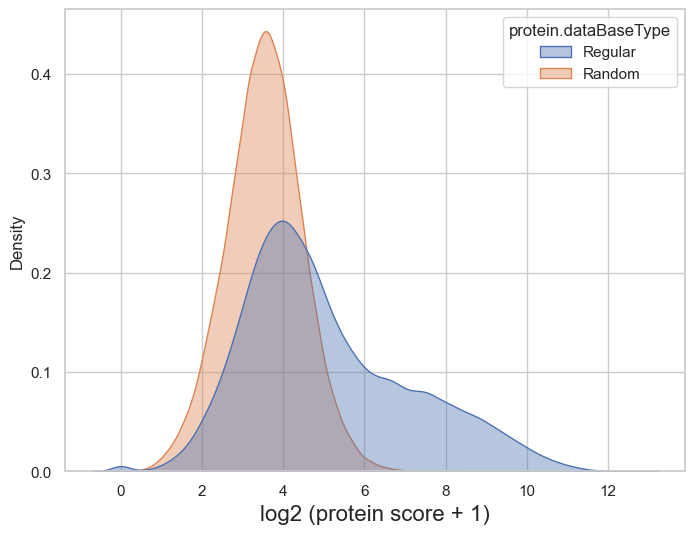

In [8]:
# Create a kernel density plot by group
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(data=df, x="protein.score", hue="protein.dataBaseType", fill=True, common_norm=False,  alpha=0.4, legend=True)
plt.xlabel('log2 (protein score + 1)', fontsize=16)        
plt.show()

In [9]:
X = df.loc[ df['protein.dataBaseType'] == 'Regular', ['protein.score']].values.reshape(-1, 1)

In [10]:
import numpy as np
from sklearn.mixture import GaussianMixture
# Suppose Data X is a 2-D Numpy array (One apple has two features, size and flavor)
GMM = GaussianMixture(n_components=2, random_state=0).fit(X)

In [11]:
y = GMM.predict(X)

<Axes: ylabel='Density'>

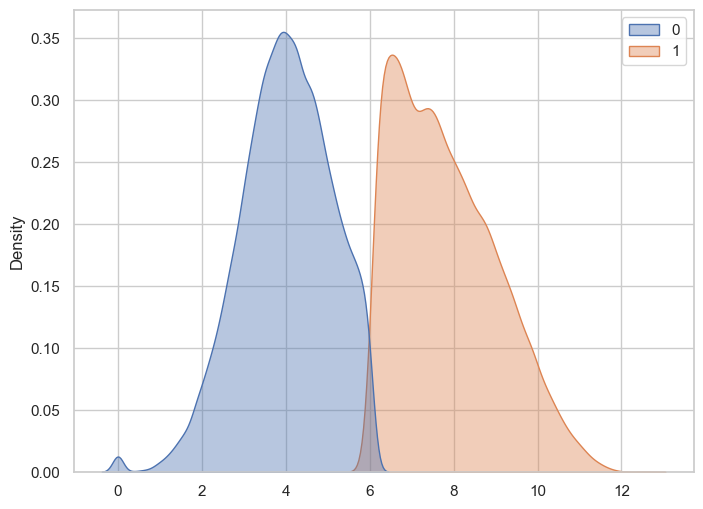

In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(x=X.squeeze(-1), hue=y, fill=True, common_norm=False,  alpha=0.4, legend=True)

In [13]:
from scipy.stats import multivariate_normal

In [14]:
d0 = df[df['protein.dataBaseType'] == 'Random']['protein.score'].values
d = df[df['protein.dataBaseType'] == 'Regular']['protein.score'].values
d = np.sort(d)

In [15]:
##Expectation step
def Estep(lis1):
    m0=lis1[0]
    m1=lis1[1]
    cov0=lis1[2]
    cov1=lis1[3]
    pi=lis1[4]
    
    pt0 = multivariate_normal.pdf(d, mean=m0, cov=cov0)
    pt1 = multivariate_normal.pdf(d, mean=m1, cov=cov1)
    w0 = (1 - pi) * pt0
    w1 = pi * pt1
    eval1 = w1/(w1 + w0)

    return(eval1)

In [16]:
## Maximization step
def Mstep(eval1):

    mu0 = (np.dot((1 - eval1), d) + np.sum(d0))/(np.sum(1 - eval1) + len(d0)) 
    mu1 = (np.dot(eval1, d))/(np.sum(eval1))
    # the weighted variance was calculated from the target protein set and the decoy set 
    # variance from the target protein set
    cov0_part1 = np.multiply((d - mu0).T, d - mu0)
    # variance from the decoy set
    cov0_part2 = np.multiply((d0 - mu0).T, d0 - mu0)
    # weighted variance
    s0_num = np.dot(cov0_part1, 1 - eval1) + np.sum(cov0_part2)
    s0_denom = np.sum(1- eval1) + len(d0)
    s0 = s0_num/s0_denom

    # for variance of the target protein set
    # only calculate the weighted variance from the target protein set
    cov1_part1 = np.multiply((d - mu1).T, d - mu1)
    s1_num = np.dot(cov1_part1, eval1)
    s1_denom = np.sum(eval1)
    s1 = s1_num/s1_denom
    
    pi = sum(eval1)/len(d)
    
    lis2=[mu0,mu1,s0,s1,pi]
    return lis2

In [17]:
def plot(lis1, xlab='xlab', ylab='ylab', title='title'):
    mu1=lis1[0]
    mu2=lis1[1]
    s1=lis1[2]
    s2=lis1[3]
    Z1 = multivariate_normal(mu1, s1)  
    Z2 = multivariate_normal(mu2, s2)
    
    plt.hist(np.concatenate((d, d0)), bins=100, density=True, alpha=0.6, color='b')
    plt.plot(d, Z1.pdf(d), 'r', alpha=0.5)
    plt.plot(d, Z2.pdf(d), 'g', alpha=0.5)
                                               # making both the axis equal
    plt.xlabel(xlab, fontsize=16)                                                  # X-Axis
    plt.ylabel(ylab, fontsize=16)                                                  # Y-Axis
    plt.title(title, fontsize=22)                                                  # Title
    plt.grid()                                                                         # displaying gridlines
    plt.show()

In [18]:
m0 = np.mean(d)
m1 = np.mean(d)
cov0 = np.cov(np.transpose(d0))
cov1 = np.cov(np.transpose(d))
pi = 0.5
max_iter = 1000

lis1=[m0,m1,cov0,cov1,pi]
lis1

[5.063110768002052,
 5.063110768002052,
 array(0.87635904),
 array(4.19324681),
 0.5]

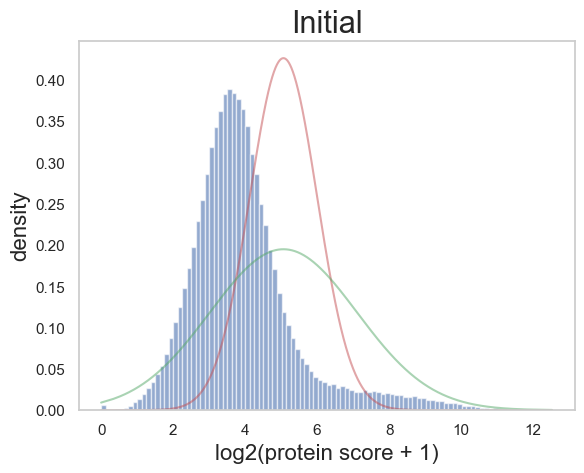

In [19]:
plot(lis1, xlab='log2(protein score + 1)', ylab='density', title='Initial')

In [20]:

for i in range(0,max_iter):
    lis2 = Mstep(Estep(lis1))
    if np.sum(np.abs(np.array(lis2) - np.array(lis1))) < 1e-8:
        break
    lis1=lis2

In [21]:
lis1

[3.551242229549515,
 6.163168626976509,
 0.8711590823395842,
 4.115275264825358,
 0.5585200657081009]

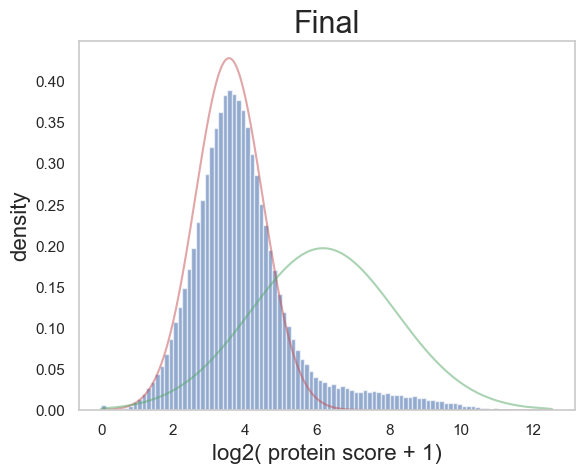

In [22]:
plot(lis1, xlab='log2( protein score + 1)', ylab='density', title='Final')

In [23]:
# calculate post protein probability

In [24]:
def calculate_post_prot_prob(x, mu0, mu1, s0, s1, pi):
    Z0 = multivariate_normal(mu0, s0)  
    Z1 = multivariate_normal(mu1, s1)
    return pi * Z1.pdf(x)/((1-pi) * Z0.pdf(x) + pi * Z1.pdf(x))

In [25]:
df['protein_probability'] = calculate_post_prot_prob(df['protein.score'].values, mu0=lis1[0], mu1=lis1[1], s0=lis1[2], s1=lis1[3], pi=lis1[4])

In [26]:
df

,protein.Accession,protein.dataBaseType,protein.score,protein_probability
1,P67809,Regular,9.620057,1.000000
2,P09651,Regular,9.363938,1.000000
10,A0A2R8Y4L2,Regular,9.361616,1.000000
14,P16070,Regular,9.294773,1.000000
30,P16989,Regular,9.249807,1.000000
...,...,...,...,...
428736,P63132,Regular,0.000000,0.889142
428738,Q9UBC5,Regular,0.000000,0.889142
428739,Q9NY46,Regular,0.000000,0.889142
428740,Q9H2K2,Regular,0.000000,0.889142


# Take maximum protein probability as the protein probability for each protein

In [27]:
df_regular = df[df['protein.dataBaseType'] == 'Regular']

In [28]:
max_values = df_regular.groupby('protein.Accession')['protein_probability'].max()
output = pd.DataFrame({'protein.Accession': max_values.index, 'protein_probability': max_values.values})

In [30]:
output.min() 

protein.Accession      A0A024RBG1
protein_probability      0.169015
dtype: object

In [74]:
protein_not_in_dat = uniprot_swiss[~uniprot_swiss['Entry'].isin(output['protein.Accession'])]['Entry'].values

In [534]:
additional_rows = ({
    'protein.Accession': protein_not_in_dat,
    'protein_probability': np.zeros(len(protein_not_in_dat))
})
output = pd.concat([output, pd.DataFrame(additional_rows)], ignore_index=True) 
output

,protein.Accession,protein_probability
0,A0A024RBG1,0.999992
1,A0A075B6J2,0.939846
2,A0A075B6K0,0.991211
3,A0A075B6K2,0.331800
4,A0A075B6K4,0.469839
...,...,...
20421,Q9UI72,0.000000
20422,Q9Y3F1,0.000000
20423,Q9Y6C7,0.000000
20424,Q9Y6Z2,0.000000


In [535]:
output.to_csv('protein_probability.csv', index=False)